# Studying the orbit of satellite galaxies

The purpose of this tutorial is to help *you* with modelling and studying the orbit of galaxies. If you need any more detail than what is described by this tutorial, check out the [galpy documentation](https://docs.galpy.org/en/latest/index.html).

There are a few things you need to consider when creating your model.
- **Firstly**: what data are you using? When you start your model, you need to have some data on the current 6D properties of your galaxy. The two main methods (that may either produce the same or different results) are 
    1. manually inputting the 6D data as a list, or 
   
    2. using the orbit.Orbit.from_name method. The from_name method imports the data from the SIMBAD database automatically. The astroquery package needs to be installed in order for SIMBAD to be queried, however galpy does also include a small list of objects saved which can be accessed by using tab completion with `Orbit.from_name('')`. 

- You can also instantiate multiple galaxies at once, by either inputting the 6D data as a multi-dimensional array, or by inputting a list of names (when using the from_name method). 3 collections of objects can also be loaded with from_name: *'MW globular clusters'*, *'MW satellite galaxies'*, and *'solar system'*.


- **Next**: what potential are you using for the Milky Way? the galpy package's default potential is 'MWPotential2014', which is described in detail in Bovy (2015), however it also includes others like McMillan17, from the McMillan (2017) paper, and more. You can also instantiate the potential from scratch, using different potential objects like the MiyamotoNagaiPotential.


- **And**: Do you want to include the LMC potential? The LMC's effects on the Milky Way influences the dynamics of neighbouring bodies, and depending on the distance from the Milky Way's centre, it's inclusion will affect how satellite galaxies orbit the Milky Way. You can either include it by making a simplified potential, ..... Or, you can include its affects on the acceleration of the Milky Way galactic centre, by calculating the resulting force of the LMC on the MW.


- **Lastly**: For what timeframe do you want to model your orbit? You can integrate your orbit forwards, backwards, or even both to compare the past modelled orbit to the predicted future orbit. You can also choose exactly how far back (or far forwards) you want to integrate the orbit, just keep in mind that the further you model from the present, the less accurate the model may become. Most of the time, integrating your galaxy just long enough for one full orbit is sufficient.

In [1]:
# Importing our libraries and packages required for the orbit
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
from galpy.util import conversion
from astropy import units

# Importing potentials.
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential

## Instantiating our galaxy "Orbit"
The first thing that we do is create a galpy Orbit object that represents our satellite galaxy. If you're inputting the initial conditions by hand, you want to make sure that you're inputting it properly so that the orbit knows what values you're using. You can set it up with [R,vR,vT,z,vz,phi] coordinates very easily, in galpy internal units. You can use the conversion module to convert between these galpy units and physical units.
```python  
o = Orbit([R,vR,vT,z,vz,phi])
```
If you have [RA(deg),DEC(deg),Dist(kpc),$\mu_\alpha^*$(mas/yr), $\mu_\delta$(mas/yr),$v_{los}$(km/s)], you don't need to convert your data into other coordinates, and can instantiate simply;
```python
o = Orbit([ra,dec,d,mu_ra,mu_dec,vlos], radec=True)
```
Lastly, you can also instantiate the orbit with retrieved 6D conditions from SIMBAD. Keep in mind that the name query needs to be identical to how it is listed on the SIMBAD database;
```python
name = "my galaxy's name"
o = Orbit.from_name(name)
```

Depending on the potential you use, you may need to set the physical conversion factors when instantiating your orbit. In the case that you aren't using MWPotential2014, and that the variable pot holds your chosen potential, set `ro = conversion.get_physical(pot)['ro']`, and `vo = conversion.get_physical(pot)['vo']`. Then you can pass ro & vo along with your 6D data when instantiating the orbit.
Or, you may want to use a different solar motion than the default. The default solar motion is from Schoenrich et al. (2010), where the solar motion [U,V,W] = **[11.1,12.24,7.25]**. Solar motions already included in galpy are: 'hogg', 'dehnen', 'schoenrich'; but you can also manually choose the solar motion in [-U,V,W]. **Note the minus sign in front of U when inputting the value manually**.

Also, if you need outputs to be in the natural galpy coordinates, you can include `o.turn_physical_off()` in your script. You can quickly convert between physical and galpy units by multiplying/dividing by galpy.unit.conversion methods; specific functions can be found in the [galpy docs](https://docs.galpy.org/en/latest/reference/conversion.html).

## Timescale choice
Now that the orbit has been initialized,our next step is to choose our timescale. This is not too important immediately, and can always be adjusted later. We choose how far we integrate, for example `t = 2` for 2Gyr, then we convert it into galpy units by introducing a conversion factor `to = conversion.time_in_Gyr(ro=ro, vo=vo)` where ro is the distance scale, and vo is the velocity scale. For most cases, **set vo=220km/s, and ro=8kpc**. We also include how many time steps we'd like to integrate with `n` *(If you need a starting point, try n=1001)*. Lastly we decide whether we are integrating our orbit forwards or backwards, by simply defining our time array to increase from 0 (forwards) :
``` python
ts= np.linspace(0.,t/to,n)
```
Or to decrease from 0 (backwards) :
```python 
ts= np.linspace(0.,-t/to,n)
``` 
*(Notice the change in sign of 't')*.
This can be done using other methods, but the important thing is that we create an array that spans a timeframe including the initial time (current time, defined as t=0).

**An alternative** to dividing by conversion factors '_o', is multiplying by astropy units, ex. instead of `t/to`, you may do `t*units.Gyr`. This is valid for more than just timescales.

## Deciding on what potential to use
This is a very important step that will impact the result of the orbit model the most.
As mentioned previously, the first step is to decide what 'base' potential we are going to use for the Milky Way. Depending on the desired model, you can choose which Milky Way potential suits your needs. Check [galpy potentials doc](https://docs.galpy.org/en/latest/reference/potential.html) for more information on this.
If you don't specify a potential, the default will be MWPotential2014, which represents the sum of the halo and disk mass distributions, but does not include the supermassive black hole at the Galactic Centre.

To prevent any errors or typos, I set `pot` = the chosen Milky Way potential and use this in my script.

**NOTE**: for some potentials, you may have to turn physical units off before integrating, see the McMillan17 example below.

### Do you want to use MWPotential2014 with an increased mass?
MWpotential2014 is created assuming a low-mass dark-matter halo, with a halo mass of 8E11 solar masses. Some papers however find a larger mass for the MW halo. If you would like to increase this mass then, you can do something like:
``` python
pot = MWPotential2014.copy()
pot[2] *= 2
```
This will double the halo mass, to 1.6E12 solar masses.

### Are you including the LMC?
Including the effect of the LMC on the Milky Way introduces more realistic dynamics to the model. To include it, you first need to instantiate the LMC as an Orbit object, and then integrate it backwards along your timescale, assuming that it experiences dynamical friction from the Milky Way.
```python
mass_lmc=1.0e11 #solar masses
rscale_lmc=5 #kpc

o_lmc= Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
cdf= ChandrasekharDynamicalFrictionForce(GMs = mass_lmc*units.Msun, rhm = rscale_lmc*units.kpc,
                                             dens=pot, ro=ro, vo=vo)
ts= np.linspace(0.,-t/to,1001)
o_lmc.integrate(ts,pot+cdf)
```

Next, you represent the LMC as a moving object potential. We do this by first modelling it as a stationary Hernquist Potential, and then implement its motion by combining this potential with its integrated orbit. It can then be added to the potential of the Milky Way. 

```python
#Moving Hernquist potential represents the LMC
pot_lmc= HernquistPotential(amp = 2*mass_lmc*units.Msun,                  #amp = 2*M
                            a = rscale_lmc*units.kpc/(1.+np.sqrt(2.))) #rhm = (1+sqrt(2))*a
moving_pot_lmc= MovingObjectPotential(o_lmc, pot=pot_lmc)

#Add LMC potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]
```

Now this total potential, `total_pot`, can be used for your satellite orbit integration.

**NOTE**: If you wish to add the LMC reflex motion for an orbit which you will be integrating forwards, you will need to account for that when setting up your potential. Instead of integrating o_lmc with a timescale that is going backwards, you will need to integrate it forwards at this point.

```python
ts= np.linspace(0.,-t/to,1001)
o_lmc.integrate(-ts,pot+cdf)
```

### Including the Milky Way centre's barycentric acceleration due to the LMC
Depending on the location of your satellite galaxy, this inclusion may not affect your orbit drastically, but it will still produce a more accurate result. We start by defining the functions that give the origin acceleration, in rectangular coordinates.
```python
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
```

These are then interpolated to speed up the numerical calculations of the NonInertialFrameForce.

```python
if o_lmc.time(use_physical=False)[0] > o_lmc.time(use_physical=False)[1]:
    t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
else:
    t_intunits= o_lmc.time(use_physical=False)
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)
```

We now compute the potential addition due to the acceleration of the origin:

```python
from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])
```

Now we're left with three components of the total potential:
- MWPotential2014 (or whatever other potential you are using for the Milky Way)
- nip (The non-inertial potential)
- moving_pot_lmc (Our potential for the moving LMC)
The total potential can now be represented as `MwPotential2014 + nip + moving_pot_lmc` or `[MWPotential2014] + [nip] + [moving_pot_lmc]` (These methods are equivalent).

## Finally modelling the orbit of your galaxy
Now the orbit can be integrated with your timescale and potential of choice.
```python
o.integrate(timescale,potential)
```
You can now plot almost any dynamic property of the orbit, like cartesian coordinates, cylindrical coordinates, right ascension and declination, etc. You can find exactly what attributes you can find by either typing `o.` and hitting TAB, or by going to the [galpy orbit attributes](https://docs.galpy.org/en/latest/reference/orbit.html#attributes) found in the documentation.
Galpy has a method that will plot your coordinates of choice, `o.plot(d1, d2)`, where d1 and d2 are the first and second dimensions, or in 3D `o.plot(d1, d2, d3)`, or as an animation `o.animate(d1, d2)` over the integrated orbit. Galpy plotting methods also allow you to input all of the usual matplotlib arguments. For example, you can change the datapoint colour to black by including `c='k'`. 

You can also always create the plots manually by using `matplotlib.pyplot` methods like so:
```python
plt.plot(o.ra(ts), o.dec(ts), 'k-')
```
Which would produce a plot of your orbit in the RA-DEC projection. You can also model your data using a segment of the timescale ts, by indexing your values, ex. `o.ra(ts)[:len(ts)/2]` would plot your orbit for only the second half of your timescale. If you don't include 'ts' when plotting, only the current (t=0) values will be plotted.

### Including uncertainties
In order to include uncertainties from the 6D data when modeling the orbit, the simplest method is assuming that the data can be characterised by a gaussian distribution. Then, by using numpy or another method, random datapoints can be generated and used in the orbit integration. For example, if your generated data `sixD_unc` is in a 2D array of shape (30,6), then `Orbit(sixD_unc)` will generate a collection of 30 orbits. 

### Retrieving some data from this orbit
As mentioned before, a lot of data is stored in the Orbit object. These can be found in [galpy orbit attributes](https://docs.galpy.org/en/latest/reference/orbit.html#attributes). Some of them aren't very helpful for plotting, but are extremely useful for understanding the orbit. For example,
```python
o.rperi()
```
will return a numerically calculated pericentre for the orbit.

3 very useful methods are `rperi()`, `rap()`, and `e()`, which respectively return the pericentre, apocentre, and eccentricity of the orbit.

### Pericentre & Apocentre in more detail:
If you're integrating an orbit with a potential that is not an inertial reference frame, **you may sometimes find that your calculated pericentre and apocentre are smaller/larger than expected**. This is because the pericentre and apocentre calculated by galpy to be the minimum and maximum radial distance from the galactic centre, respectively. This problem will arise if your orbit is integrated with more than one orbital period.

One way to get the nearest pericentre & apocentre values without re-integrating the orbit is using scipy and numpy.

**NOTE**: Remember that you want to integrate your orbit backwards when calculating the pericentres & apocentres, so make sure that ts is set up properly for that.

```python
tdisrupt = 5
ts = np.linspace(0, -tdisrupt/to, 1000)

from scipy.signal import argrelextrema
peri_indx = argrelextrema(o.r(ts), np.less)[0] # returns indices of local minima
apo_indx = argrelextrema(o.r(ts), np.greater)[0] # returns indices of local maxima

peri_nearest = o.r(ts)[(peri_indx)[0]]
apo_nearest = o.r(ts)[(apo_indx)[0]]
```

`peri_nearest` is the first pericentre in the integrated orbit, while similarily `apo_nearest` is the first apocentre.

An example of how this calculation differs from galpy's methods is shown near the end of the example notebook.

# Example notebook

In my example, I'll be modelling the orbit of the dwarf galaxy **Antlia II**.

In [2]:
## 6D Data and uncertainties from Dr. Andrew Pace's recent paper
sixD = [142.8868, -36.7673, 132, -0.093, 0.1, 290.7]
sigma = [0, 0, 6, 0.008, 0.009, 0.5]

pot = MWPotential2014
ro = 8.
vo = 220.
mo = conversion.mass_in_msol(ro=ro, vo=vo)
solarmotion = [-11.1, 12.24, 7.25]

# How many data points I want, taking into account the uncertainty
N_unc = 100
sixD_unc = np.random.normal(loc=sixD, scale=sigma, size = (N_unc,6))

In [3]:
# Initializing the orbits
o = Orbit(sixD, radec=True, solarmotion=solarmotion)
o_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

In [4]:
# Initializing the timescale, so that I can integrate backwards 5Gyrs
t = 5
to = conversion.time_in_Gyr(ro=ro,vo=vo)
n = 1001
ts= np.linspace(0.,-t/to,n)

In [5]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)

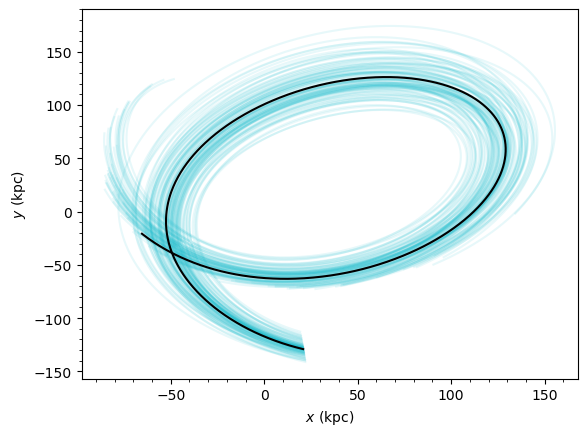

In [6]:
# Plotting.
o_unc.plot(d1='x', d2='y', alpha=0.1, c='#17becf')
o.plot(d1='x', d2='y', overplot=True, c='k')

### If I want to see how the LMC affects the orbit:

In [7]:
## Including the effects from the LMC:
mass_lmc=1.0e11 #solar masses
rscale_lmc=5 #kpc

o_lmc= Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
cdf= ChandrasekharDynamicalFrictionForce(GMs = mass_lmc*units.Msun, rhm = rscale_lmc*units.kpc,
                                             dens=pot, ro=ro, vo=vo)
ts= np.linspace(0.,-t/to,1001)
o_lmc.integrate(ts,pot+cdf)

#Moving Hernquist potential represents the LMC
pot_lmc= HernquistPotential(amp = 2*mass_lmc*units.Msun,                  #amp = 2*M
                            a = rscale_lmc*units.kpc/(1.+np.sqrt(2.))) #rhm = (1+sqrt(2))*a
moving_pot_lmc= MovingObjectPotential(o_lmc, pot=pot_lmc)

#Add LMC potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]

In [8]:
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

if o_lmc.time(use_physical=False)[0] > o_lmc.time(use_physical=False)[1]:
    t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
else:
    t_intunits= o_lmc.time(use_physical=False)
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

In [9]:
newpot = pot + moving_pot_lmc + nip

In [10]:
# At current update 26.07.2023, for some reason I can't get the monte carlo
#  integration to work without the kernel dying, so I'll skip that this time

olmc = Orbit(sixD, radec=True, solarmotion=solarmotion)
# olmc_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

# Integrating the orbits
olmc.integrate(ts, pot=newpot)
# olmc_unc.integrate(ts, pot=newpot)

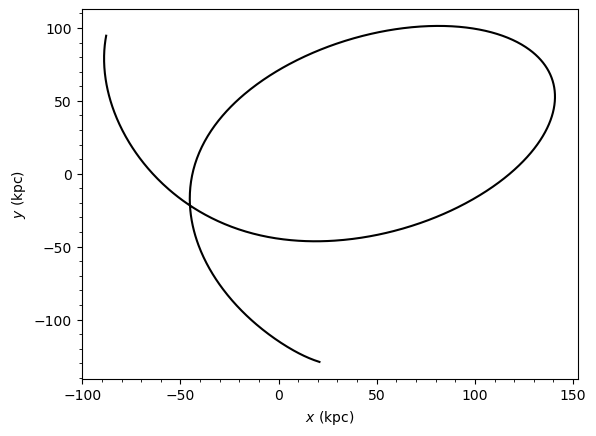

In [11]:
# Plotting.
# olmc_unc.plot(d1='x', d2='y', alpha=0.1, c='#17becf')
olmc.plot(d1='x', d2='y', c='k') #overplot = True

### If I want to try a different MW potential - McMillan17

In [12]:
from galpy.potential.mwpotentials import McMillan17
potmcmillan = McMillan17

omc = Orbit(sixD, radec=True, solarmotion=solarmotion)
omc_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

# Need to turn physical units off in order to integrate w/out any errors
omc.turn_physical_off()
omc_unc.turn_physical_off()

# Integrating the orbits
omc.integrate(ts, pot=potmcmillan)
omc_unc.integrate(ts, pot=potmcmillan)

# Turning them back on for easy plotting
omc.turn_physical_on()
omc_unc.turn_physical_on()

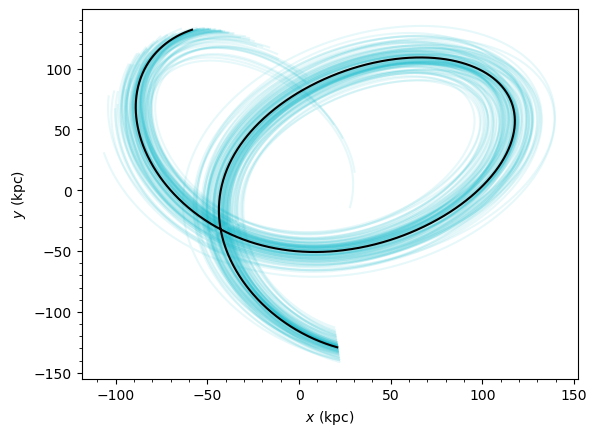

In [13]:
# Plotting.
omc_unc.plot(d1='x', d2='y', alpha=0.1, c='#17becf')
omc.plot(d1='x', d2='y', overplot=True, c='k')

### If I want to increase the potential halo mass by 1.8

In [14]:
potincmass = MWPotential2014.copy()
potincmass[2]*=1.8

oinc = Orbit(sixD, radec=True, solarmotion=solarmotion)
oinc_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

# Integrating the orbits
oinc.integrate(ts, pot=potincmass)
oinc_unc.integrate(ts, pot=potincmass)

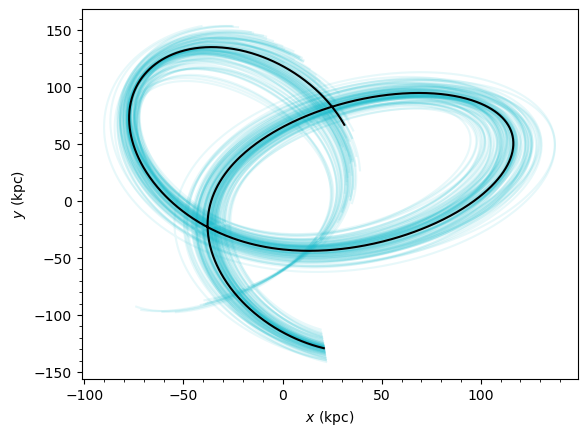

In [15]:
# Plotting.
oinc_unc.plot(d1='x', d2='y', alpha=0.1, c='#17becf')
oinc.plot(d1='x', d2='y', overplot=True, c='k')

### Comparing all 4 of these plots (without the uncertainties) using various potentials:

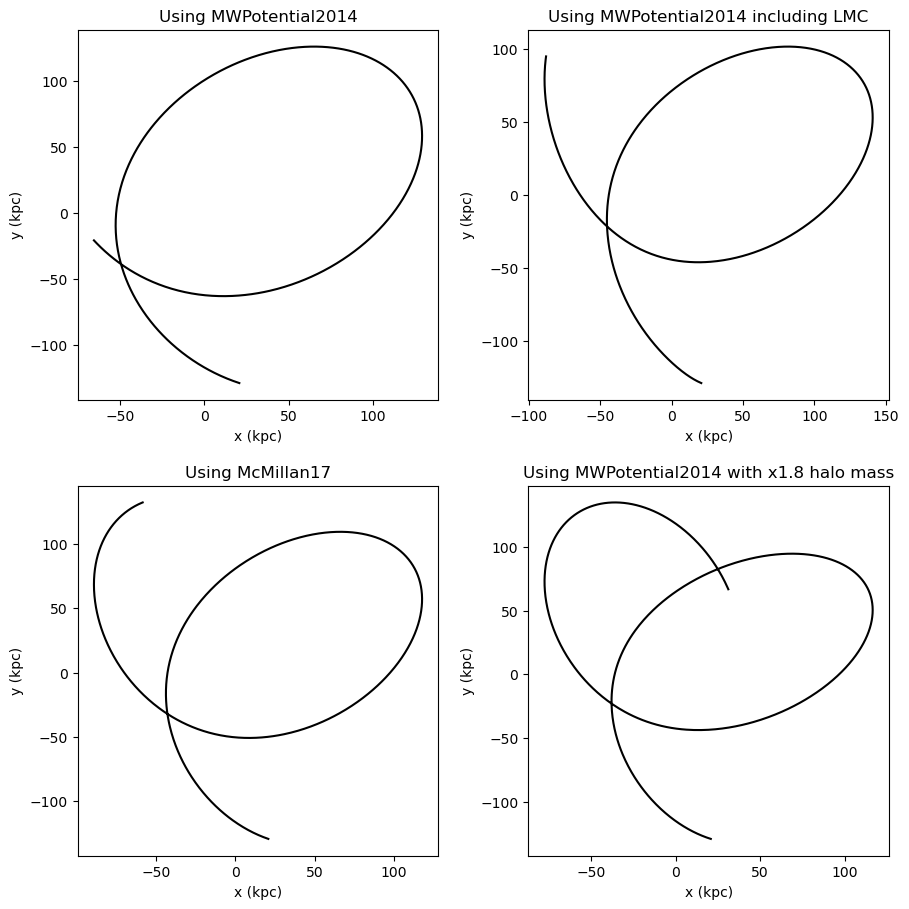

In [16]:
fig, axs = plt.subplots(2,2, figsize=(9,9))

axs[0,0].plot(o.x(ts), o.y(ts), c='k')
axs[0,0].set_title('Using MWPotential2014')
axs[0,1].plot(olmc.x(ts), olmc.y(ts), c='k')
axs[0,1].set_title('Using MWPotential2014 including LMC')
axs[1,0].plot(omc.x(ts), omc.y(ts), c='k')
axs[1,0].set_title('Using McMillan17')
axs[1,1].plot(oinc.x(ts), oinc.y(ts), c='k')
axs[1,1].set_title('Using MWPotential2014 with x1.8 halo mass')
plt.tight_layout(w_pad = 3, h_pad=3)

for ax in axs.flat:
    ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
    
plt.show()

In [17]:
# Printing each of their pericentres.
print(o.rperi())
print(olmc.rperi())
print(omc.rperi())
print(oinc.rperi())

61.04179718161516
43.035062886361175
49.58028942544041
41.16547744267741


### Below I'll include examples of the various (but not all) projections that can be plotted using the data kept in Orbit objects

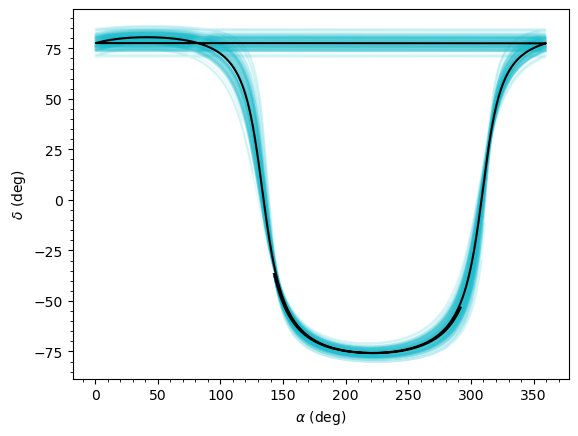

In [18]:
# ra vs. dec projection
o_unc.plot(d1='ra', d2='dec', alpha=0.1, c='#17becf')
o.plot(d1='ra', d2='dec', overplot=True, c='k')

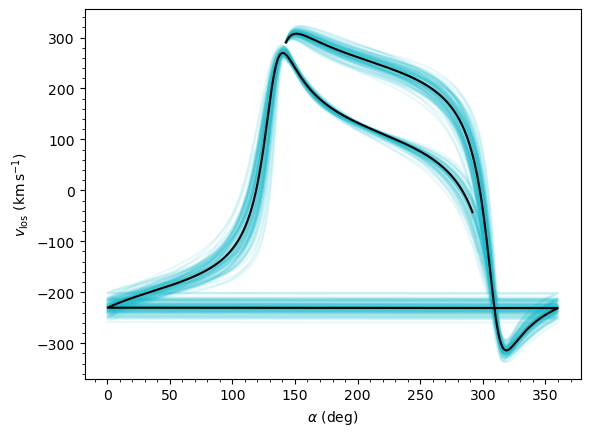

In [19]:
# radial (line of sight) velocity vs. ra projection
o_unc.plot(d1='ra', d2='vlos', alpha=0.1, c='#17becf')
o.plot(d1='ra', d2='vlos', overplot=True, c='k')

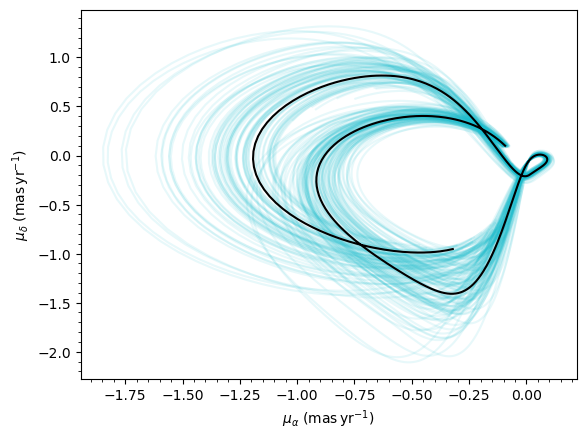

In [20]:
# proper motions projection
o_unc.plot(d1='pmra', d2='pmdec', alpha=0.1, c='#17becf')
o.plot(d1='pmra', d2='pmdec', overplot=True, c='k')

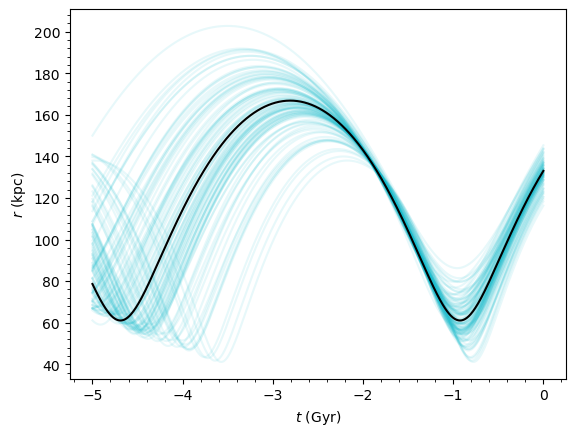

In [21]:
# radial distance vs. time
o_unc.plot(d1='t', d2='r', alpha=0.1, c='#17becf')
o.plot(d1='t', d2='r', overplot=True, c='k')

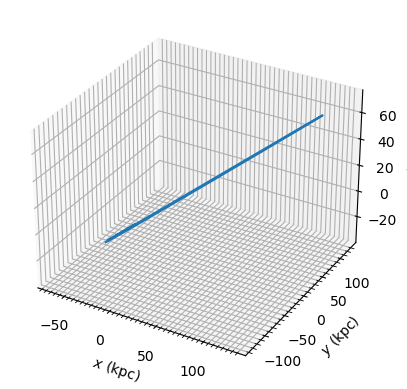

In [22]:
# 3D cartesian projection
o.plot3d()

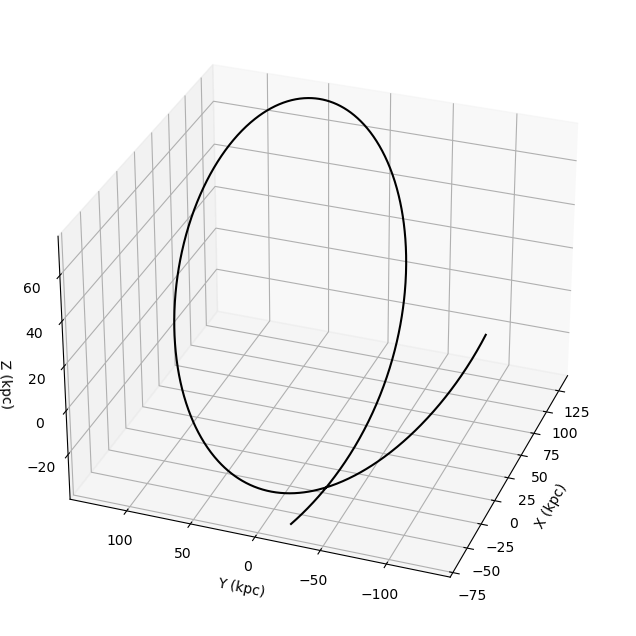

In [23]:
# Same plot as above but created manully, so that I can rotate the axes
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(o.x(ts), o.y(ts), o.z(ts), c = 'k')

ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

ax.view_init(30,200)
plt.show()

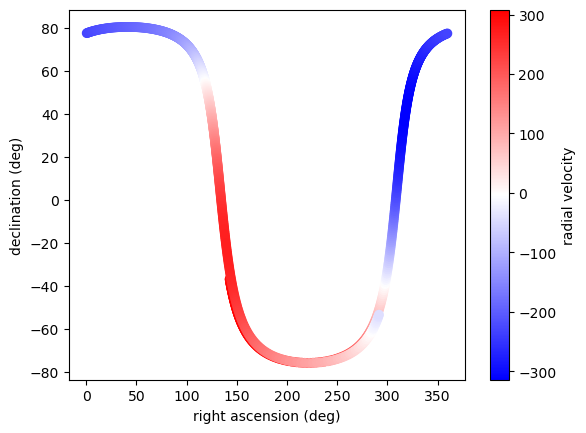

In [24]:
# Plotting three dimensions on a 2d plot using colour maps
# Radial velocity vs. ra & dec
plt.scatter(x = o.ra(ts), y=o.dec(ts), c=o.vlos(ts), cmap='bwr')
plt.colorbar(label='radial velocity')
plt.xlabel('right ascension (deg)')
plt.ylabel('declination (deg)');

## Pericentre & Apocentre calculation methods

Galpy's calculated pericentre 21.699402889303308
vs. the minimum radial distance 21.699402889303308
Galpy's calculated apocentre 144.06843852646477
vs. the maximum radial distance 144.06843852646477


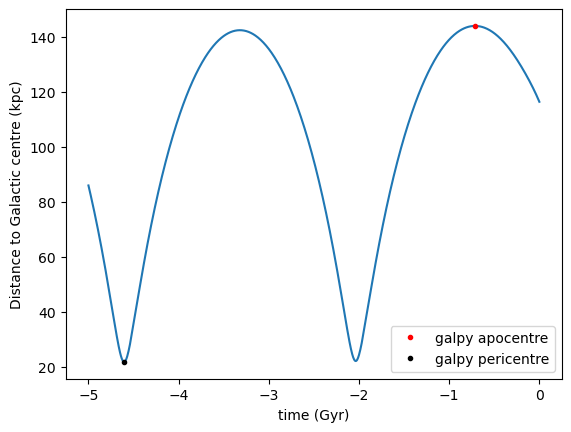

In [25]:
test = Orbit.from_name('CraterII')
time = ts # using same ts as above in the example

# Integrating the orbits
test.integrate(time, pot=newpot)

plt.plot(time*to, test.r(time))
plt.xlabel('time (Gyr)')
plt.ylabel('Distance to Galactic centre (kpc)')

plt.plot(time[np.argmax(test.r(time))]*to, test.rap(), 'r.', label='galpy apocentre')
plt.plot(time[np.argmin(test.r(time))]*to, test.rperi(), 'k.', label='galpy pericentre')
plt.legend()

print("Galpy's calculated pericentre",test.rperi())
print("vs. the minimum radial distance",min(test.r(time)))
print("Galpy's calculated apocentre",test.rap())
print("vs. the maximum radial distance",max(test.r(time)))

In [26]:
import numpy as np
from scipy.signal import argrelextrema

# for local maxima
apo_indx = argrelextrema(test.r(time), np.greater)[0]
print('Indices where a maximum occurs are at', apo_indx)

# for local minima
peri_indx = argrelextrema(test.r(time), np.less)[0]
print('Indices where a minimum occurs are at', peri_indx)

#print(test.r(-ts)[peri_indx[0][1]]) #test.r(-ts)[peri_indx[1]], test.r(-ts)[659], test.r(-ts)[917])
print('First pericentre is at', test.r(time)[peri_indx[0]], 'kpc')
print('Second pericentre is at', test.r(time)[peri_indx[1]], 'kpc')
print('First apocentre is at', test.r(time)[apo_indx[0]], 'kpc')
print('Second apocenter is at', test.r(time)[apo_indx[1]], 'kpc')

Indices where a maximum occurs are at [143 664]
Indices where a minimum occurs are at [407 921]
First pericentre is at 22.02997201626833 kpc
Second pericentre is at 21.699402889303308 kpc
First apocentre is at 144.06843852646477 kpc
Second apocenter is at 142.51007594178554 kpc
